#  Exercise: Burger's Equation

\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is 
$$u(x,t=0)=a(x).$$

Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### Reference Implementation
- [Implementation is available in Kaggle with name: DeepONet4Burgers](https://www.kaggle.com/code/yhzang32/deeponet4burgers)
- [The training and testing Datasets](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

##  (1) Load training and testing dataset

The shape of a_train: torch.Size([1000, 128])
The shape of uT_train: torch.Size([1000, 128])
The shape of x_trian: torch.Size([128, 1])


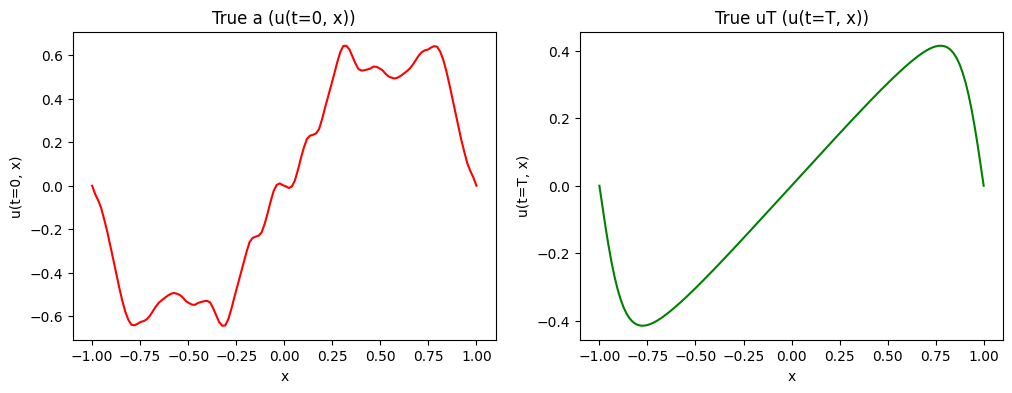

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(3407)
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('Burgers_train.mat', 'r')
data_test = h5py.File('Burgers_test.mat', 'r')
#
def get_data(data, dtype):
    a = torch.tensor(np.array(data["u0"]).T, dtype=dtype)
    u = torch.tensor(np.array(data["u_sol"]).T, dtype=dtype)
    uT = u[:,-1,:]
    #
    gridx = torch.tensor(np.array(data['x_mesh']), dtype=dtype)
    #
    a = a.reshape(a.shape[0], -1)
    uT = uT.reshape(a.shape[0], -1)
    
    return a, uT, gridx
#
a_train, uT_train, x_train = get_data(data_train, dtype)
a_test, uT_test, x_test = get_data(data_test, dtype)
print('The shape of a_train:', a_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of x_trian:', x_train.shape)

####### Visualize the training data 
a_show, uT_show = a_train[0], uT_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
axs.flat[:][0].plot(x_train.flatten(), a_show.flatten(), color='r')
axs.flat[:][0].set_title('True a (u(t=0, x))')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('u(t=0, x)')
#
axs.flat[:][1].plot(x_train.flatten(), uT_show.flatten(), color='green')
axs.flat[:][1].set_title('True uT (u(t=T, x))')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('u(t=T, x)')
#
plt.show()

### (2) The DeepONet architecture 

In [2]:
import torch.nn as nn
#
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        self.branch_net(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:-1]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        # output layer
        net.append(nn.Linear(hidden_in, layers_branch[-1], dtype=dtype))
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:-1]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        # output layer
        net.append(nn.Linear(hidden_in, layers_trunk[-1], dtype=dtype))
        self.trunk = nn.Sequential(*net)
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.activation_trunk(self.trunk(x))
        # size(batch_size, a_size) -> size(batch_size, p)
        b = self.branch(a)
        #
        output = torch.einsum("bp,mp->bm", b, t) + self.bias
        return output
#
layers_trunk = [x_train.shape[-1], 128, 128, 128, 128]
layers_branch = [a_train.shape[-1], 128, 128, 128, 128]
#
model_uT = DeepONet(layers_trunk, layers_branch).to(device)
#
from torchsummary import summary
summary(model_uT, [(1,), (128,)], device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
              ReLU-2                  [-1, 128]               0
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
             ReLU-11                  [-1, 128]               0
             ReLU-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
             ReLU-14                  [

### (3) The loss function
$$
L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \sqrt{\sum_{j=1}^{N_p} \left| \mathcal{G}_\theta(a^{(i)}(\Xi))(x_j) - u^{(i)}(x_j) \right|^2}
$$

In [3]:
class LossClass(object):

    def __init__(self, uT_model):
        self.device = device
        self.uT_model = uT_model 
    
    def loss_data(self, a_batch, uT_batch):
        '''loss term'''
        x, a, uT = x_train.to(self.device), a_batch.to(self.device), uT_batch.to(self.device)
        #
        uT_pred = self.uT_model(x, a) 
        loss = torch.norm(uT-uT_pred, 2, 1)
        loss = torch.mean(loss)
        
        return loss 

    def get_error(self, a, uT):
        '''L2 relative error'''
        x, a, uT = x_train.to(self.device), a.to(self.device), uT.to(self.device)
        # 
        uT_pred = self.uT_model(x, a)
        error = torch.norm(uT-uT_pred, 2, 1) / torch.norm(uT, 2, 1)

        return torch.mean(error)

### (4) Training the model

In [4]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, uT:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            uT: size(batch_size, uT_size)
        '''
        self.a = a 
        self.uT = uT
    
    def __getitem__(self, index):
        return self.a[index], self.uT[index]

    def __len__(self):
        return self.a.shape[0]
        
train_loader = DataLoader(MyDataset(a_train, uT_train), batch_size=50, shuffle=True)

################# Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_uT.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, uT_batch in train_loader:
        lossClass = LossClass(model_uT)
        loss_train = lossClass.loss_data(a_batch, uT_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    with torch.no_grad():
        error = lossClass.get_error(a_test, uT_test)
        error_list.append(error.item())
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
        print('error_test:', error_list.pop())
print('The consuming time is:', time.time()-t0)

  5%|██                                      | 105/2000 [00:02<00:50, 37.66it/s]

Epoch:99, The loss is:0.07576590031385422
error_test: 0.0399312749505043


 10%|████                                    | 205/2000 [00:05<00:44, 39.96it/s]

Epoch:199, The loss is:0.05542508885264397
error_test: 0.026748530566692352


 15%|██████▏                                 | 307/2000 [00:07<00:44, 38.40it/s]

Epoch:299, The loss is:0.06215560436248779
error_test: 0.02942575514316559


 20%|████████                                | 406/2000 [00:10<00:42, 37.12it/s]

Epoch:399, The loss is:0.042385559529066086
error_test: 0.019938472658395767


 25%|██████████                              | 504/2000 [00:12<00:38, 39.02it/s]

Epoch:499, The loss is:0.046006254851818085
error_test: 0.03647570312023163


 30%|████████████                            | 604/2000 [00:15<00:33, 42.09it/s]

Epoch:599, The loss is:0.025395551696419716
error_test: 0.012944303452968597


 35%|██████████████▏                         | 708/2000 [00:17<00:31, 40.88it/s]

Epoch:699, The loss is:0.0324125662446022
error_test: 0.01798332668840885


 40%|████████████████▏                       | 808/2000 [00:20<00:29, 40.81it/s]

Epoch:799, The loss is:0.025922665372490883
error_test: 0.014641323126852512


 45%|██████████████████▏                     | 907/2000 [00:22<00:28, 38.55it/s]

Epoch:899, The loss is:0.023321662098169327
error_test: 0.01365162804722786


 50%|███████████████████▌                   | 1005/2000 [00:25<00:22, 43.38it/s]

Epoch:999, The loss is:0.020460663363337517
error_test: 0.013636181131005287


 55%|█████████████████████▌                 | 1105/2000 [00:27<00:20, 43.51it/s]

Epoch:1099, The loss is:0.01561650913208723
error_test: 0.00906091183423996


 60%|███████████████████████▍               | 1203/2000 [00:30<00:21, 37.59it/s]

Epoch:1199, The loss is:0.0150254862383008
error_test: 0.009796367026865482


 65%|█████████████████████████▍             | 1307/2000 [00:32<00:17, 40.26it/s]

Epoch:1299, The loss is:0.015027761459350586
error_test: 0.010350501164793968


 70%|███████████████████████████▍           | 1407/2000 [00:35<00:14, 40.91it/s]

Epoch:1399, The loss is:0.013478326611220837
error_test: 0.009241116233170033


 75%|█████████████████████████████▍         | 1507/2000 [00:37<00:12, 40.66it/s]

Epoch:1499, The loss is:0.016720907762646675
error_test: 0.007070179563015699


 80%|███████████████████████████████▎       | 1608/2000 [00:40<00:09, 42.31it/s]

Epoch:1599, The loss is:0.011126449331641197
error_test: 0.005638356786221266


 85%|█████████████████████████████████▎     | 1708/2000 [00:42<00:06, 41.75it/s]

Epoch:1699, The loss is:0.009531726129353046
error_test: 0.005186776630580425


 90%|███████████████████████████████████▎   | 1808/2000 [00:45<00:04, 39.83it/s]

Epoch:1799, The loss is:0.011161086149513721
error_test: 0.007109953556209803


 95%|█████████████████████████████████████▏ | 1905/2000 [00:47<00:02, 42.57it/s]

Epoch:1899, The loss is:0.009991711936891079
error_test: 0.006544479168951511


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.11it/s]

Epoch:1999, The loss is:0.009978482499718666
error_test: 0.006784498225897551
The consuming time is: 49.88214612007141


### (5) Performance on testing dataset
The relative error:
$$
L^2 = \sqrt{\sum_i\frac{\|u(x_i)-u_{nn}(x_i)\|^2}{\|u(x_i)\|^2}}
$$
where $u$ represents the true solution and $u_{nn}$ is the network approximation.

The shape of uT_pred: torch.Size([200, 128])
The average l2 error: tensor(0.0068)


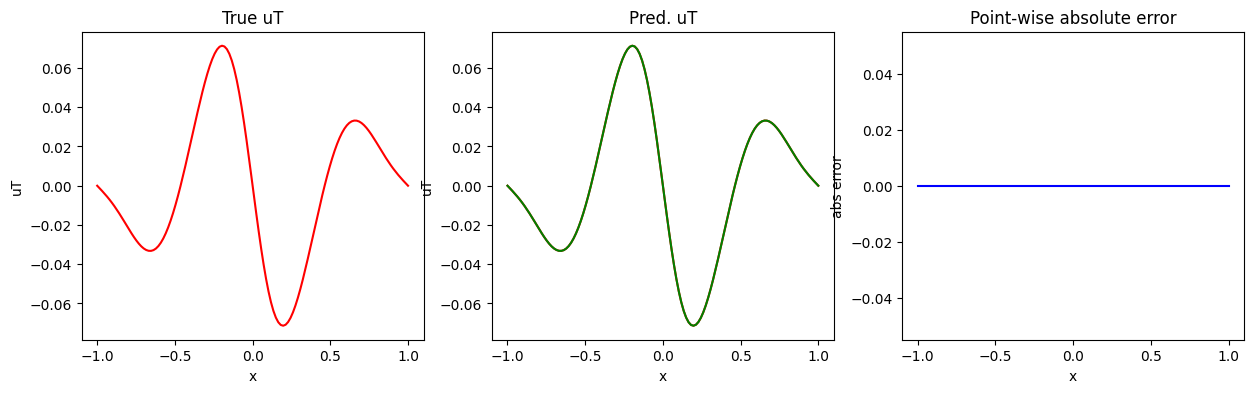

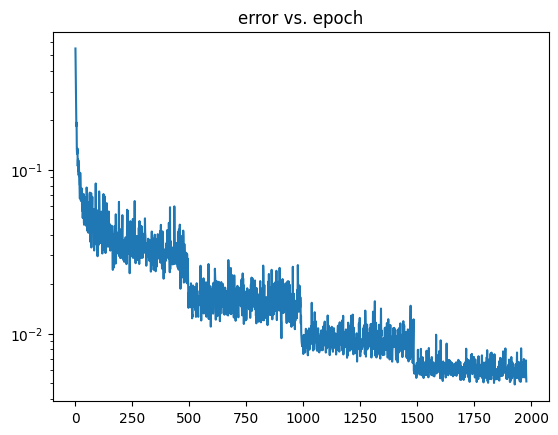

In [6]:
#######################################
# The L2 relative error
#######################################
def L2_error(uT, uT_pred):
    ''' '''
    l2 = torch.norm(uT-uT_pred, 2, 1) / torch.norm(uT, 2, 1)
    return l2
# Make prediction with trained model
uT_test_pred = model_uT(x_test.to(device), a_test.to(device)).detach().cpu()
print('The shape of uT_pred:', uT_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(uT_test, uT_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
inx = 0
uT_true, uT_pred = uT_test[inx], uT_test_pred[inx]
#
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
axs.flat[:][0].plot(x_test.flatten(), uT_true.flatten(), color='r')
axs.flat[:][0].set_title('True uT')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('uT')
#
axs.flat[:][1].plot(x_test.flatten(), uT_true.flatten(), color='r')
axs.flat[:][1].plot(x_test.flatten(), uT_true.flatten(), color='green')
axs.flat[:][1].set_title('Pred. uT')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('uT')
#
axs.flat[:][2].plot(x_test.flatten(), (uT_true - uT_true).flatten(), color='blue')
axs.flat[:][2].set_title('Point-wise absolute error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('abs error')
#
plt.show()
#############################
plt.figure()
plt.semilogy(error_list)
plt.title('error vs. epoch')
plt.show()